## Setting everything up

In [1]:
import os
#import iris
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
#set logistical global vars
R_earth = 6367.47 #km
dphi = 0.25*np.pi/180. #radians, this is also dlambda

data_array = pd.read_csv('/project2/geos39650/jet_stream/data/t2m_temp_1207_0208.csv') #this one is with latitude cut aboe mexio

### Formatting

In [3]:
data_array

,latitude,longitude,time,t2m,area_grid,temp_bracket
0,90.00,0.00,2007-12-02,255.99916,4.726606e-14,"(251, 256]"
1,90.00,0.00,2007-12-09,257.67792,4.726606e-14,"(256, 261]"
2,90.00,0.00,2007-12-16,254.52310,4.726606e-14,"(251, 256]"
3,90.00,0.00,2007-12-23,250.64710,4.726606e-14,"(246, 251]"
4,90.00,0.00,2007-12-30,249.62552,4.726606e-14,"(246, 251]"
...,...,...,...,...,...,...
5644795,20.25,359.75,2008-02-03,289.98940,7.242024e+02,"(286, 291]"
5644796,20.25,359.75,2008-02-10,293.87262,7.242024e+02,"(291, 296]"
5644797,20.25,359.75,2008-02-17,296.12430,7.242024e+02,"(296, 301]"
5644798,20.25,359.75,2008-02-24,294.18283,7.242024e+02,"(291, 296]"


In [4]:
#convert to radians because fuck degrees
if data_array['latitude'][0] >80: #just to make sure i dont do the multiplication twice
    data_array['latitude'] *= np.pi/180
    data_array['longitude'] *= np.pi/180
#make temperature bins
Tmin = min(data_array.t2m)
Tmax = max(data_array.t2m) #kelvin
Tbins = range(int(Tmin),int(Tmax),5)
weeks = range(len(data_array['time'].unique())) #should be 14 weeks, but just in case, this makes it flexible
times = data_array.time

## Actually start analyzing 

In [61]:
#all analysis functions
def prob_plots(binedges,pdf,xlab,cdf=None):
    if cdf is not None:
        plt.plot(binedges,cdf,label='cdf')
    plt.plot(binedges,pdf,label='pdf')
    plt.xlabel('bin edges [temp]')
    plt.ylabel(xlab)
    plt.legend()
    plt.show()
    
def globe_plots(xarr,titlestr="",contour=False,contours=None):
    #set up the axes for a globe
    plt.subplots(figsize = (10, 10))
    ax = plt.axes(projection=ccrs.Orthographic(20, 90))
    #coolcool now we can plot it
    
    if contour:
        if contours is None:
            contours=range(int(xarr.min()),int(xarr.max()),10)
        xarr.plot.contourf(ax=ax,
                           transform=ccrs.PlateCarree(),
                           levels=contours,
                           cbar_kwargs={'orientation': 'horizontal',
                                    'pad': 0.05,
                                    'shrink': 0.5,
#                                     'spacing': 'proportional',
                                    'ticks':contours}
                                       )
    else:
        xarr.plot(ax=ax, transform=ccrs.PlateCarree())
        
    ax.set_title(titlestr)
    #make it draw the pretty continents
    ax.set_global(); ax.coastlines();
    #draw lat-lon isocontours
    ax.gridlines()
    ax.plot()
    plt.show()
    
def dists_of_boxes(temp_df,plot=False):
    #number of boxes at each temp
    pdf_boxes, binedges = np.histogram(temp_df,bins=Tbins)
    #number of boxes below each temp
    cdf_boxes=np.cumsum(pdf_boxes)
    if plot:
        prob_plots(binedges[:-1],pdf_boxes,'number of boxes',cdf=cdf_boxes)
    return binedges[:-1], pdf_boxes, cdf_boxes

#area 
def dists_of_areas(temp_df,lat,plot=False):
    #weight entry by box area so that y axis is no longer the number of boxes, but rather the area taken up by each box
    #this is the area of each grid cell
    #lat = air_df['lat'][air_df['lat']>20]*np.pi/180. #np.linspace(np.pi/2.,np.pi/2.*(1-1/4.),num=100)
    areas = (R_earth*dphi)**2 * np.cos(lat)
    pdf_areas, binedges = np.histogram(temp_df,bins=Tbins,weights=areas)
    cdf_areas=np.cumsum(pdf_areas)
    if plot:
        prob_plots(binedges[:-1],pdf_areas,'area [km^2]',cdf=cdf_areas)

    return binedges[:-1], pdf_areas, cdf_areas

#convert area to effective latitude
def dists_of_lat_eff(cdf_areas,binedges=None,plot=False):
    """if plot is set to true, must specify binedges"""
    #A = 2piR^2 (1-sin(lat_eff))
    #so 1-A/(2piR^2) = sin(lat_eff)
    #but remember latitude is defined to start at pi at the north pole
    pdf_lat_effs = np.pi/2.-np.arccos(1-cdf_areas / (2*np.pi*R_earth**2) )
    if plot:
        prob_plots(binedges,pdf_lat_effs,'effective lat')
    return pdf_lat_effs

def T_ref(data_array,temp_binedges,pdf_lat_effs):
    #take a lat point
    true_lat = data_array.latitude
    #calculate T_ref with just the latitude, given the effective lat vs temp contour relation
    T_ref = np.interp(true_lat,np.flip(pdf_lat_effs),np.flip(temp_binedges))
    return T_ref #just a func of latitude
    
def T_prime(data_array,temp_binedges,pdf_lat_effs):
    Tref = T_ref(data_array,temp_binedges,pdf_lat_effs)
    #calculate T'(lat,lon) which is T_true(lat,lon,time) - T_ref(lat,lon,time)
    Tprime =  data_array.t2m - Tref #this is a function of longitude and time
    return Tprime

def true_T_to_lat_eff(data_array,temp_binedges,pdf_lat_effs):
    temps = data_array.t2m
    lat_eff = np.interp(temps,temp_binedges,pdf_lat_effs)
    return lat_eff

def convert_to_xarray(sequence,plot=False,contour=False, contours=None, titlestr=r"$T'(\phi,\lambda) =  T(\phi,\lambda) - T_{ref}(\phi) $"):
    """this assumes a very specific structure to the sequence 
    (0.25 deg resolution on regular grid, latitudes only above 20 deg)
    that probably only works for the specific data array I am using in this notebook"""
    #hard code my coords because I'm only going to use this
    latitude_coords = np.flip(np.arange(20.25,90.001,step=0.25))
    longitude_coords = np.arange(0,360,step=0.25)

    z = np.array(sequence).reshape((280,1440))
    xarr = xr.DataArray(z,
                       dims = ('lat','lon'),
                       coords={'lat':latitude_coords,'lon':longitude_coords})
    if plot:
        globe_plots(xarr,titlestr,contour=contour,contours=contours)
    
    return xarr

/home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


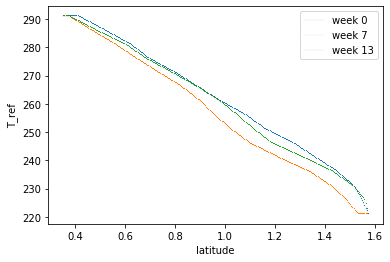

In [65]:
#compare maps of several different weeks
week_to_eval = times[0]
binedgs, pdf_area,cdf_area = dists_of_areas(data_array.t2m[times==week_to_eval],data_array.latitude[times==week_to_eval],plot=False)
pdf_lat_effs = dists_of_lat_eff(cdf_area,binedges=binedgs,plot=False)
T_ref_0 = T_ref(data_array[times==week_to_eval],binedgs,pdf_lat_effs)
week_to_eval = times[7]
binedgs, pdf_area,cdf_area = dists_of_areas(data_array.t2m[times==week_to_eval],data_array.latitude[times==week_to_eval],plot=False)
pdf_lat_effs = dists_of_lat_eff(cdf_area,binedges=binedgs,plot=False)
T_ref_7 = T_ref(data_array[times==week_to_eval],binedgs,pdf_lat_effs)
week_to_eval = times[13]
binedgs, pdf_area,cdf_area = dists_of_areas(data_array.t2m[times==week_to_eval],data_array.latitude[times==week_to_eval],plot=False)
pdf_lat_effs = dists_of_lat_eff(cdf_area,binedges=binedgs,plot=False)
T_ref_13 = T_ref(data_array[times==week_to_eval],binedgs,pdf_lat_effs)

plt.plot(data_array.latitude[times==week_to_eval],T_ref_0,alpha=0.05,marker=',',label='week 0')
plt.plot(data_array.latitude[times==week_to_eval],T_ref_7,alpha=0.05,marker=',',label='week 7')
plt.plot(data_array.latitude[times==week_to_eval],T_ref_13,alpha=0.05,marker=',',label='week 13')
plt.xlabel('latitude')
plt.ylabel('T_ref')
plt.legend()
plt.show()

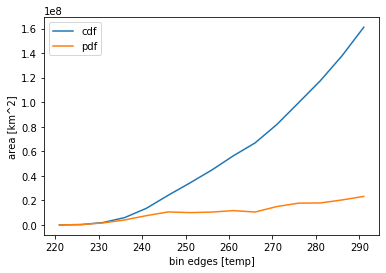

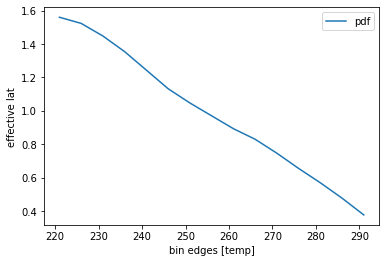

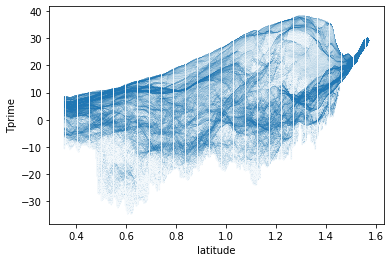

In [7]:
week_to_eval = times[5]
binedgs, pdf_area,cdf_area = dists_of_areas(data_array.t2m[times==week_to_eval],data_array.latitude[times==week_to_eval],plot=True)
pdf_lat_effs = dists_of_lat_eff(cdf_area,binedges=binedgs,plot=True)
Tprime= T_prime(data_array[times==week_to_eval],binedgs,pdf_lat_effs)
plt.plot(data_array.latitude[times==week_to_eval],Tprime,alpha=0.05,marker=',')
plt.xlabel('latitude')
plt.ylabel('Tprime')
plt.show()

## Plots!

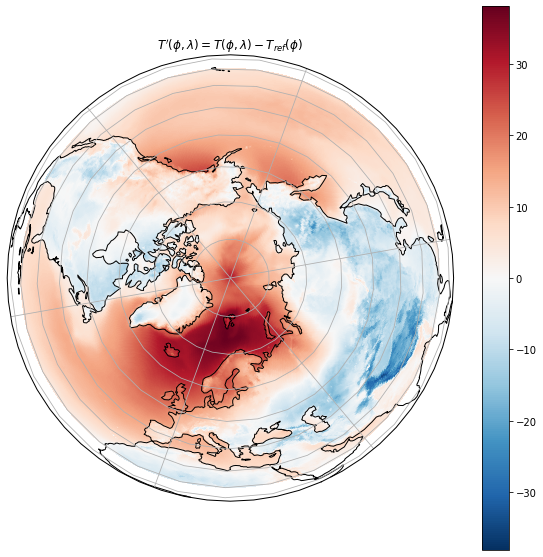

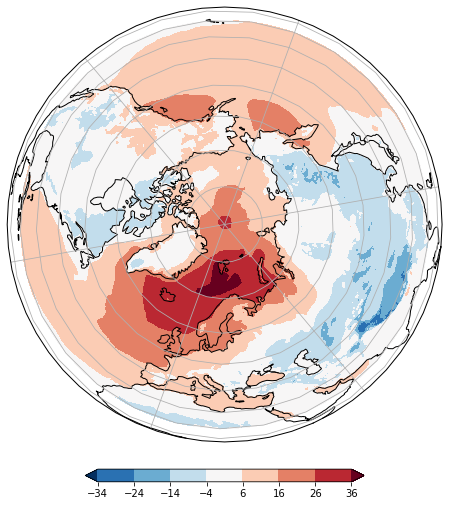

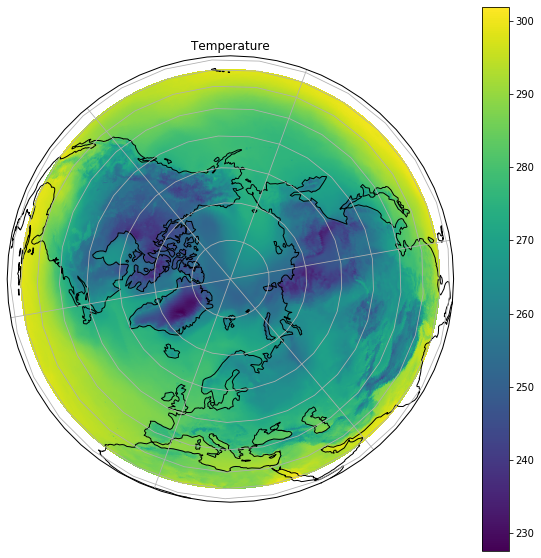

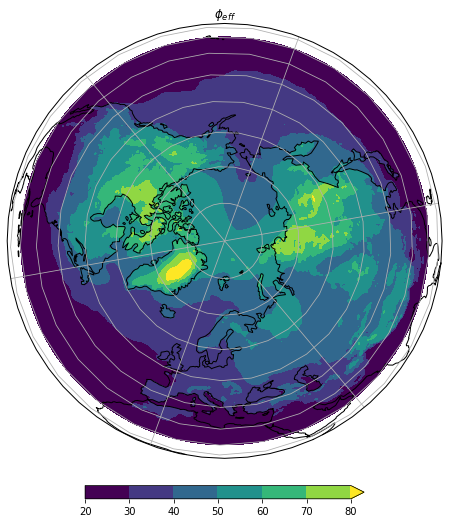

In [62]:
#plot T' on a globe
#plt.subplots(figsize = (10, 10))
x_Tp = convert_to_xarray(Tprime,plot=True)
globe_plots(x_Tp,contour=True)
temp=convert_to_xarray(data_array.t2m[times==times[0]],plot=True,titlestr='Temperature')
lat_contours = range(20,90,10)
phi_effs = true_T_to_lat_eff(data_array[times==times[0]],binedgs,pdf_lat_effs)*180/np.pi
x_phi_eff = convert_to_xarray(phi_effs, plot=True,titlestr=r"$\phi_{eff}$",contour=True,contours=lat_contours)

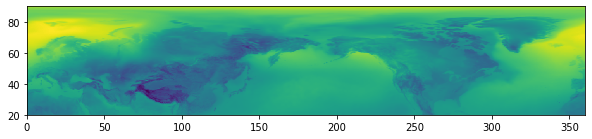

In [63]:
#Alternatively, plot it on a plane
fig, ax = plt.subplots(figsize = (10, 10))
z = np.array(Tprime).reshape((280,1440))
#print(z[:,0])
plt.imshow(z, extent=(0, 360, 20, 90))#, aspect = 'auto')
#plt.colorbar()
plt.show()

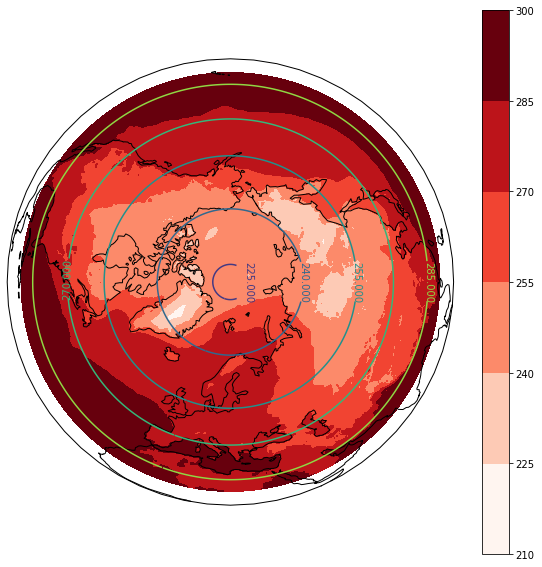

In [66]:
#look at Tref vs T
x_Tref=convert_to_xarray(T_ref_7)
x_temp = convert_to_xarray(data_array.t2m[times==times[7]])
#plot
plt.subplots(figsize = (10, 10))
ax = plt.axes(projection=ccrs.Orthographic(20, 90))
x_temp.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),cmap='Reds')
CS=x_Tref.plot.contour(ax=ax,transform=ccrs.PlateCarree())
ax.clabel(CS, inline=1, fontsize=10)
ax.set_global()
ax.coastlines()

## Tests and messing around

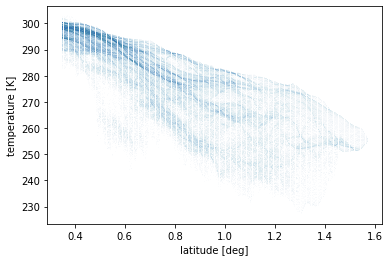

In [21]:
plt.plot(lats[times==times[0]]*180/np.pi,Temps[times==times[0]], marker=',',alpha=0.015)
plt.xlabel('latitude [deg]')
plt.ylabel('temperature [K]')
plt.show()

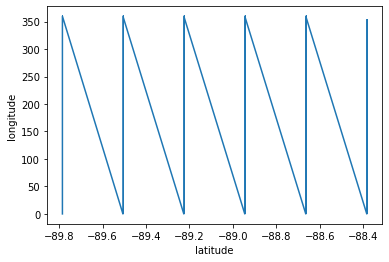

In [29]:
plt.plot(lat[:1000000],air_week_df['lon'][:1000000],marker=',')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()

In [14]:
print(air.groupby(['time'], as_index=False)['t2m'].count())

         time     t2m
0  2007-12-02  542080
1  2007-12-09  542080
2  2007-12-16  542080
3  2007-12-23  542080
4  2007-12-30  542080
5  2008-01-06  542080
6  2008-01-13  542080
7  2008-01-20  542080
8  2008-01-27  542080
9  2008-02-03  542080
10 2008-02-10  542080
11 2008-02-17  542080
12 2008-02-24  542080
13 2008-03-02  542080


In [53]:
#angular resolution (lon) of reported temp data is coarser at poles (Every 20deg) than at mid-lat (~every 2 deg). 
#at equator, its every 0.33? deg
#this makes sense because it would be pretty expensive to have it every 0.25 deg at poles!
first_air_week_df.lon[np.logical_not(np.isnan(first_air_week_df.t2m))][129600:129670]
#print(np.sum(np.logical_not(np.isnan(first_air_week_df.t2m))),len(first_air_week_df.t2m))

2465393    160.96
2465404    161.28
2465413    161.60
2465423    161.92
2465432    162.24
            ...  
2466082    181.76
2466092    182.08
2466102    182.40
2466113    182.72
2466123    183.04
Name: lon, Length: 70, dtype: float64

In [ ]:
#-------test whether ivans thing counts the nans ---------# (never ran)
air_week_df = air_week_df.assign(temp_bracket =  pd.cut(air_week_df['t2m'], cut_off))
air_week_df_high = air_week_df[air_week_df.lat > 20]
air_week_df_group_north_pdf = ai
r_week_df_north.groupby(['temp_bracket', 'time'], as_index=False)['lat'].count()
# Calculate cumulative number of grids per temperature bins
air_week_df_group_north_cdf = air_week_df_group_north_pdf.assign(lat_cumsum = air_week_df_group_north_pdf.lat.cumsum())
air_week_df_group_north_cdf['left_temp_interval']  = air_week_df_group_north_cdf.temp_bracket.apply(lambda x: x.left)

In [16]:
len(air_week.isel(time=5)['lat'])

640

In [69]:
np.all(ds_grib['values']['lon']==ds_grib['longitude'])#['longitude'][(ds_grib['latitude']<0.4)&(ds_grib['latitude']> 0)]

<xarray.DataArray ()>
array(True)
Coordinates:
    number   int64 0
    step     timedelta64[ns] 00:00:00
    surface  int64 0

In [79]:
len(ds_grib['longitude'][ds_grib['latitude']>89.78])

18

In [81]:
ds_grib_cut = ds_grib[[ds_grib['latitude']>20]]

KeyboardInterrupt: 

In [ ]:
ds_grib_cut

In [86]:
np.isnan(ds_grib_reshaped)

<xarray.Dataset>
Dimensions:     (lat: 640, lon: 11942, time: 184)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2007-12-01 ... 2008-03-01T12:00:00
    step        timedelta64[ns] 00:00:00
    surface     int64 0
    latitude    (lon, lat) float64 -89.78 -89.51 -89.23 -88.95 ... nan nan nan
    longitude   (lon, lat) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    valid_time  (time) datetime64[ns] 2007-12-01 ... 2008-03-01T12:00:00
  * lon         (lon) float64 0.0 0.2812 0.2963 0.3 ... 359.7 359.7 359.7 359.7
  * lat         (lat) float64 -89.78 -89.51 -89.23 -88.95 ... 89.23 89.51 89.78
Data variables:
    t2m         (time, lon, lat) bool False False False False ... True True True

In [94]:
ds_grib_week = ds_grib.resample(time='1W').mean()
df_grib_week = ds_grib_week.to_dataframe().filter(['latitude', 'longitude', 't2m'])
a = df_grib_week.reset_index(drop=False)
a = a[a.time == '2007-12-02']
a_group = a.groupby(['latitude'], as_index=False).longitude.count()

KeyError: ('latitude', 'longitude', 't2m')

In [91]:
ds_grib

<xarray.Dataset>
Dimensions:     (time: 184, values: 542080)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2007-12-01 ... 2008-03-01T12:00:00
    step        timedelta64[ns] 00:00:00
    surface     int64 0
    latitude    (values) float64 89.78 89.78 89.78 ... -89.78 -89.78 -89.78
    longitude   (values) float64 0.0 20.0 40.0 60.0 ... 280.0 300.0 320.0 340.0
    valid_time  (time) datetime64[ns] 2007-12-01 ... 2008-03-01T12:00:00
  * values      (values) MultiIndex
  - lon         (values) float64 0.0 20.0 40.0 60.0 ... 280.0 300.0 320.0 340.0
  - lat         (values) float64 89.78 89.78 89.78 ... -89.78 -89.78 -89.78
Data variables:
    t2m         (time, values) float32 247.30748 247.49889 ... 224.41501
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2020-01-30T21:06:00 GRIB to CDM+CF via cfgrib-0....

In [57]:
data_array = pd.read_csv('/project2/geos39650/jet_stream/data/t2m_temp_1207_0208.csv')

In [51]:
#fig, ax = plt.subplots(figsize = (20, 20))
print(len(data_array.t2m)/14)
#temp_grid = np.array(data_array['t2m'])
#temp_grid_week1 = temp_grid[:int(len(data_array.t2m)/13)]
#plt.plot(data_array.latitude,data_array.longitude,marker=',')
print(1440*720)
#plt.show()
#temp_grid = temp_grid.resize((len(data_array.latitude),len(data_array.longitude)))
#data_array.plot()

403200.0
1036800


In [55]:
data_array = pd.read_csv('/project2/geos39650/jet_stream/data/t2m_temp_1207_0208.csv')
data_array.set_index(['latitude', 'longitude', 'time'], inplace=True)
data_array.count()

t2m             5644800
area_grid       5644800
temp_bracket    5644800
dtype: int64

TypeError: Invalid shape (5644800,) for image data

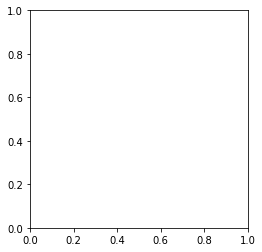

In [74]:
plt.imshow((np.array(data_array.t2m).reshape

In [87]:
np.array(data_array.t2m[:5643000]).reshape((2375,2376))

array([[255.99916, 257.67792, 254.5231 , ..., 243.21518, 246.89442,
        247.59566],
       [252.9362 , 248.91232, 247.85942, ..., 250.6471 , 249.62552,
        249.91008],
       [246.69974, 243.21518, 246.89442, ..., 247.29417, 255.99916,
        257.67792],
       ...,
       [297.2029 , 296.51587, 296.79306, ..., 291.19803, 291.05746,
        291.5383 ],
       [294.55444, 293.53278, 292.57053, ..., 295.43552, 295.62686,
        293.85608],
       [295.4376 , 295.53394, 295.70703, ..., 295.99722, 295.9684 ,
        295.73315]])

In [97]:
len(np.array(data_array.t2m))/1440/14

280.0

In [113]:
z = np.array(data_array.t2m).reshape((280,1440,14))
len(z[0])

1440

In [98]:
(90-20)*4

280

## Code for when data was in .grib files
and in a reduced gaussian grid

In [4]:
#load data
ds_grib = xr.load_dataset(
    '/project2/geos39650/jet_stream/reanalysis_getter/cdsapi_requested_files/cds_dec07-feb08_12hrs.grib', 
    engine='cfgrib')

#fix indexing because the way it is done by default is stupid
index = pd.MultiIndex.from_arrays(
    [ds_grib.longitude.values, 
     ds_grib.latitude.values], 
    names=['lon', 'lat']
)
ds_grib['values'] = index

ds_grib_reshaped = ds_grib.unstack('values')


In [8]:
#air = ds_grib_reshaped.t2m.T
air = ds_grib_reshaped.t2m.T

#average each week
air_week = air.resample(time='1W').mean()
air_week_df = air_week.to_dataframe()
air_week_df = air_week_df.reset_index(drop=False).filter(['lat', 'lon', 'time', 't2m'])

/home/afarah/.conda/envs/jetstream/lib/python3.6/site-packages/xarray/core/dataarray.py:1897: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return self.transpose()


In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
air.isel(time=100).plot()

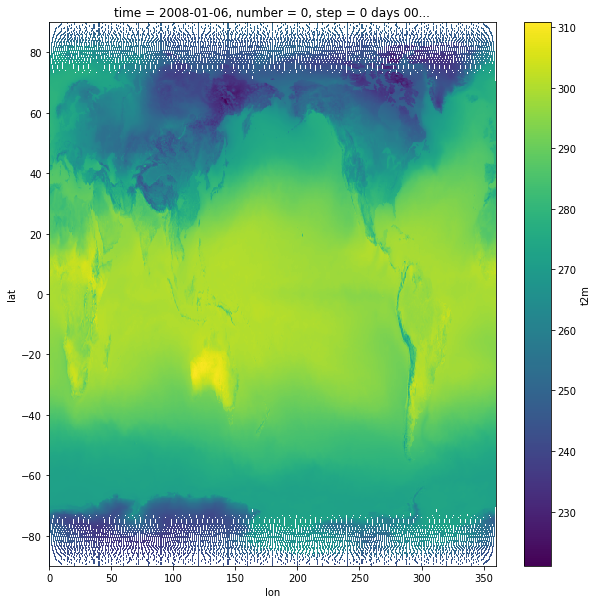

In [11]:
fig, ax = plt.subplots(figsize = (10, 10))
air_week.isel(time=5).plot() 

In [10]:
#--- MOAR FORMATTING! ----#
#lets just look at the first week
# first_air_week = air_week.isel(time=0)
# first_air_week_df = first_air_week.to_dataframe()
# first_air_week_df = first_air_week_df.reset_index(drop=False).filter(['lat', 'lon', 'time', 't2m'])

# Temp = first_air_week_df['t2m'][first_air_week_df['lat']>20] 
# Temp = np.linspace(Tmin,Tmax,num=100)
# Temp += np.random.normal(loc=50,scale=50, size=100)

#ok now look at all of the weeks
weeks = range(13)
all_weeks_df =air_week.isel(time=weeks).to_dataframe().reset_index(drop=False).filter(['lat', 'lon', 'time', 't2m'])
#put a cut to only look above ~mexico
lat_cut_bools = all_weeks_df['lat']>20 
# temp_all_weeks_df = all_weeks_df['t2m'][lat_cut_bools] 

#dataframes ill be using as inputs to functions
Temps = all_weeks_df['t2m'][lat_cut_bools] 
times = all_weeks_df['time']
lats  = all_weeks_df['lat'][lat_cut_bools]*np.pi/180.

#make temp bins
Tmin = min(Temps)
Tmax = max(Temps) #kelvin
Tbins = range(int(Tmin),int(Tmax),5)

In [50]:
#all analysis functions
def plots(binedges,pdf,cdf,xlab):
    plt.plot(cdf,binedges,label='cdf')
    plt.plot(pdf,binedges,label='pdf')
    plt.ylabel('bin edges [temp]')
    plt.xlabel(xlab)
    plt.legend()
    plt.show()
    
def dists_of_boxes(temp_df,plot=False):
    #number of boxes at each temp
    pdf_boxes, binedges = np.histogram(temp_df,bins=Tbins)
    #number of boxes below each temp
    cdf_boxes=np.cumsum(pdf_boxes)
    if plot:
        plots(binedges[:-1],pdf_boxes,cdf_boxes,'number of boxes')
    return binedges[:-1], pdf_boxes, cdf_boxes

#area 
def dists_of_areas(temp_df,lat,plot=False):
    #weight entry by box area so that y axis is no longer the number of boxes, but rather the area taken up by each box
    #this is the area of each grid cell
    #lat = air_df['lat'][air_df['lat']>20]*np.pi/180. #np.linspace(np.pi/2.,np.pi/2.*(1-1/4.),num=100)
    areas = (R_earth*dphi)**2 * np.cos(lat)
    pdf_areas, binedges = np.histogram(temp_df,bins=Tbins,weights=areas)
    cdf_areas=np.cumsum(pdf_areas)
    if plot:
        plots(binedges[:-1],pdf_areas,cdf_areas,'area [km^2]')

    return binedges[:-1], pdf_areas, cdf_areas

#convert area to effective latitude
def dists_of_lat_eff(cdf_areas,binedges=None,plot=False):
    """if plot is set to true, must specify binedges"""
    #A = 2piR^2 (1-sin(lat_eff))
    #so 1-A/(2piR^2) = sin(lat_eff)
    #but remember latitude is defined to start at pi at the north pole
    pdf_lat_effs = np.pi/2.-np.arccos(1-cdf_areas / (2*np.pi*R_earth**2) )
    cdf_lat_effs = np.cumsum(pdf_lat_effs)
    if plot:
        plots(binedges,pdf_lat_effs,pdf_lat_effs,'effective lat')
    return pdf_lat_effs

def T_prime(data_array,binedges,pdf_lat_effs):
    #take a lat,lon point
    true_lat = data_array.latitude
    true_long =data_array.longitude
    #calculate T_ref with just the latitude, given the effective lat vs temp contour relation
    T_ref = np.interp(true_lat,pdf_lat_effs,binedges)
    #calculate T'(lat,lon) which is T_true(lat,lon,time) - T_ref(lat,lon,time)
    Tprime = T_ref - data_array.t2m #this is a function of longitude and time
    return Tprime, data_array.longitude, data_array.time

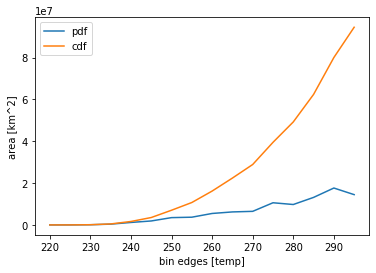

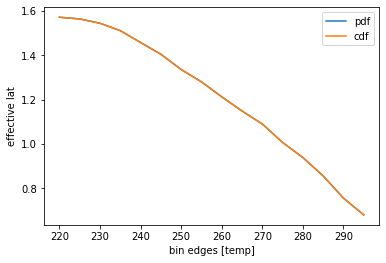

0           NaN
1      1.563757
2      1.516448
3      1.412669
4      1.255504
         ...   
247         NaN
248         NaN
249         NaN
250         NaN
251         NaN
Name: eff_latitude, Length: 252, dtype: float64


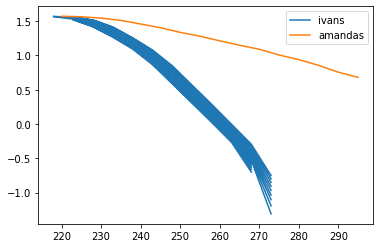

In [13]:
# #test it out with the first week
binedgs, pdf_area,cdf_area = dists_of_areas(Temps[times==times[0]],lats[times==times[0]],plot=True)
pdf_lat_effs = dists_of_lat_eff(cdf_area,binedges=binedgs,plot=True)

#compare with iván's analysis
ivans = pd.read_csv('/project2/geos39650/jet_stream/data/t2m_per_eff_latitude.csv')
print(ivans['eff_latitude'])
plt.plot(ivans['left_temp_interval'],ivans['eff_latitude'],label='ivans')
plt.plot(binedgs,pdf_lat_effs,label='amandas')
plt.legend()
plt.show()

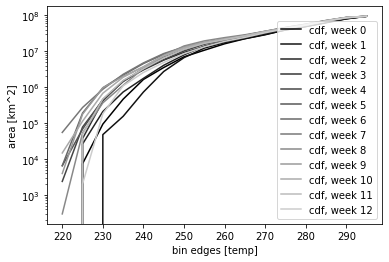

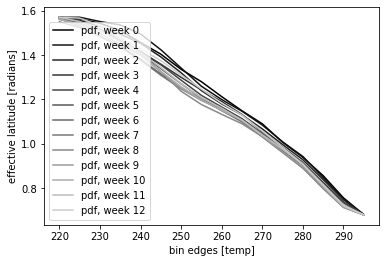

In [14]:
#now for realzies with all weeks
pdf_lat = np.zeros([len(weeks),len(Tbins)-1])
cdf_area = np.zeros([len(weeks),len(Tbins)-1])
colors = np.linspace(0,0.8,num=len(weeks),dtype=str)
for w in weeks:
    timestamp = times[w]
    this_week_temp = Temps[times==timestamp]
    x,pdf,cdf_area[w,:] = dists_of_areas(this_week_temp,lats[times==timestamp])
    pdf_lat[w,:],cdf = dists_of_lat_eff(cdf_area[w,:])
    plt.plot(x,cdf_area[w],label='cdf, week %i'%w,c=colors[w])
plt.legend()
plt.xlabel('bin edges [temp]')
plt.ylabel('area [km^2]')
plt.yscale('log')
plt.show()

for w in weeks:
    plt.plot(x,pdf_lat[w],label='pdf, week %i'%w,c=colors[w])
plt.legend()
plt.xlabel('bin edges [temp]')
plt.ylabel('effective latitude [radians]')
plt.show()

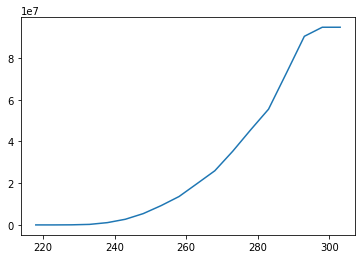

In [45]:
plt.plot(x,cdf_area[0])

plt.show()

In [44]:
# data_to_save = pd.DataFrame()
# left_temps = np.tile(x,(len(weeks),1))
#data_to_save['left_temp_interval']=left_temps
# data_to_save['cdf_area']=cdf_area
# data_to_save['pdf_lat']=pdf_lat
path_to_save = '/project2/geos39650/jet_stream/data/amanda/'
np.savetxt(path_to_save+'left_temp_interval.csv',x)
np.savetxt(path_to_save+'times.csv',times)
np.savetxt(path_to_save+'cdf_area.csv',cdf_area)
np.savetxt(path_to_save+'pdf_lat.csv',pdf_lat)